# Flight delay prediction
Flight delays not only irritate passengers but also have a significant cost for both companies and air-traverlers.
According to [airlines.org](https://www.airlines.org/dataset/u-s-passenger-carrier-delay-costs/#:~:text=Assuming%20%2447%20per%20hour*%20as,2018%20to%20be%20%2428%20billion.) assuming $\$$47 per hour to be the average value of a passenger's time, flight delays have cost air travelers billions of dollars.
The FAA even estimated that the annual cost of flight delays would be around $28 billion!

In this mini-poject we aim to get statistical insight on what is most likely to cause flight delays, we will also use a linear regression model with the MLlib Spark library in order to estimate the arrival delay knowing the delays that occured before takeoff.
Finally we will upload it to a powerful cloud cluster. As a matter of fact, we will leverage the computational power provided by the Amazon AWS Elastic Map Reduce service in order to train it faster.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import sqlite3

In [4]:
%%javascript
var rate = 0;
// apply setting to  all current CodeMirror instances
IPython.notebook.get_cells().map(
    function(c) {  return c.code_mirror.options.cursorBlinkRate=rate;  }
);

// make sure new CodeMirror instance also use this setting
CodeMirror.defaults.cursorBlinkRate=rate;

<IPython.core.display.Javascript object>

# 1 - Data loading and cleaning
#### Data loading
We use the pandas `read_csv` to load our data in a pandas dataframe. We drop the `Unnamed: 27` column which results from a parsing error.

In [5]:
df = pd.read_csv("datasets/2009.csv")
df = df.drop("Unnamed: 27", axis = 1)
df.head()

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,...,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,2009-01-01,XE,1204,DCA,EWR,1100,1058.0,-2.0,18.0,1116.0,...,0.0,62.0,68.0,42.0,199.0,NaN,NaN,NaN,NaN,NaN
1,2009-01-01,XE,1206,EWR,IAD,1510,1509.0,-1.0,28.0,1537.0,...,0.0,82.0,75.0,43.0,213.0,NaN,NaN,NaN,NaN,NaN
2,2009-01-01,XE,1207,EWR,DCA,1100,1059.0,-1.0,20.0,1119.0,...,0.0,70.0,62.0,36.0,199.0,NaN,NaN,NaN,NaN,NaN
3,2009-01-01,XE,1208,DCA,EWR,1240,1249.0,9.0,10.0,1259.0,...,0.0,77.0,56.0,37.0,199.0,NaN,NaN,NaN,NaN,NaN
4,2009-01-01,XE,1209,IAD,EWR,1715,1705.0,-10.0,24.0,1729.0,...,0.0,105.0,77.0,40.0,213.0,NaN,NaN,NaN,NaN,NaN


#### Data interpretation
We want to predict the value of the `ARRIVAL_DELAY` from each feature known before the takeoff.
That is 
- `CRS_DEP_TIME`: The scheduled departure time
- `DEP_TIME`: The actual departure time
- `WHEELS_OFF`: time before takeoff
- `DEP_DELAY`: departure delay
- `TAXI_OUT`: time from taxi of origin gate to wheels off
- `CRS_ARR_TIME`: scheduled arrival time
- `CRS_ELAPSED_TIME`: scheduled elapsed time
- `DISTANCE`: distance between airports in miles
- `SECURITY_DELAY`: delay at security

In [8]:
df_clean = df[["CRS_DEP_TIME", "DEP_TIME", "WHEELS_OFF", "DEP_DELAY", "TAXI_OUT", "CRS_ARR_TIME",
               "CRS_ELAPSED_TIME", "DISTANCE", "SECURITY_DELAY", "ARR_DELAY"]]

df_clean.head()

,CRS_DEP_TIME,DEP_TIME,WHEELS_OFF,DEP_DELAY,TAXI_OUT,CRS_ARR_TIME,CRS_ELAPSED_TIME,DISTANCE,SECURITY_DELAY,ARR_DELAY
0,1100,1058.0,1116.0,-2.0,18.0,1202,62.0,199.0,NaN,4.0
1,1510,1509.0,1537.0,-1.0,28.0,1632,82.0,213.0,NaN,-8.0
2,1100,1059.0,1119.0,-1.0,20.0,1210,70.0,199.0,NaN,-9.0
3,1240,1249.0,1259.0,9.0,10.0,1357,77.0,199.0,NaN,-12.0
4,1715,1705.0,1729.0,-10.0,24.0,1900,105.0,213.0,NaN,-38.0


## Feature selection
We initially have 27 input features, we would like to reduce this number in order to prevent overfitting and to improve our model training speed (essential in our case where the dataset has a size of a few GB).
#### Correlation matrix
In case of a big dataset like this one, it would be to computationaly expensive to perform Recursive Feature Selection, therefore we use the correlation matrix method to identify:
- weak linear dependencies between features and the output column (`ARR_DELAY`): these variables have poor value for training in training our linear model. (low absolute correlation means low linear dependency)
- strong linear dependencies between input features: these variable are redundant, therefore we delete them to prevent overfitting (i.e. to prevent our model to learn from statistical noise).

In [10]:
corr = df.corr()

In [11]:
def print_corr_matrix(corr):
    """
        Pretty print the correlation matrix
    """
    fig, ax = plt.subplots(figsize = (11, 9))

    cmap = sb.diverging_palette(0, 230, 90, 60, as_cmap=True)
    mask = np.triu(np.ones_like(corr, dtype=bool))[1:, :-1]
    corr2 = corr.iloc[1:, :-1].copy()

    sb.heatmap(corr2, mask = mask, vmin = -1, vmax = 1, cmap = cmap, annot = True, fmt = ".2f", annot_kws={"fontsize":8})

    plt.show()

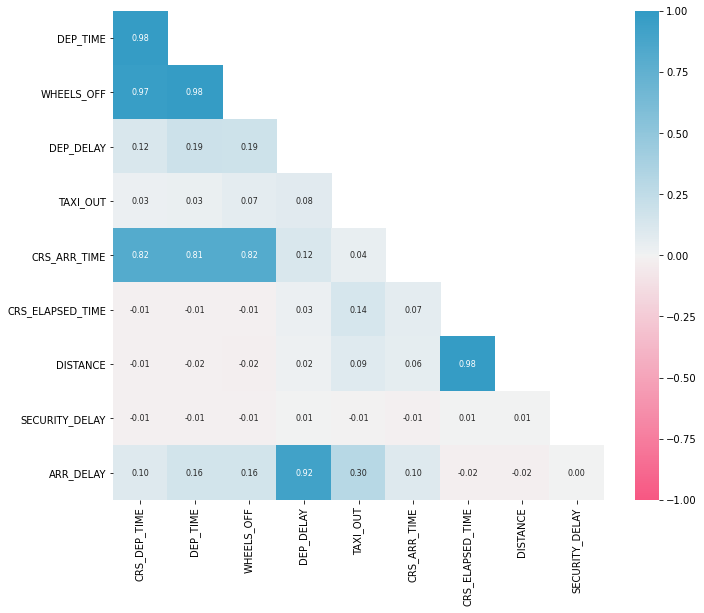

In [12]:
corr_clean = df_clean.corr()
print_corr_matrix(corr_clean)

#### Features selection
We have a high correlation between these pairs of features 
- (`DEP_TIME`, `CRS_DEP_TIME`)
- (`WHEELS_OFF`, `CRS_DEP_TIME`)
- (`WHEELS_OFF`, `DEP_TIME`)
- (`CRS_ARR_TIME`, `CRS_DEP_TIME`)
- (`CRS_ARR_TIME`, `DEP_TIME`)
- (`CRS_ARR_TIME`, `WHEELS_OFF`)
- (`DISTANCE`, `CRS_ELAPSED_TIME`) 

Therefore we delete `CRS_DEP_TIME`, `WHEELS_OFF`, `DISTANCE`, `CRS_ARR_TIME`, which are redondant in order to reduce the chances of overfitting and to increase the model accuracy.

In [13]:
df_clean2 = df_clean.drop(["CRS_DEP_TIME", "WHEELS_OFF", "DISTANCE", "CRS_ARR_TIME"], axis = 1)
df_clean2.head()

,DEP_TIME,DEP_DELAY,TAXI_OUT,CRS_ELAPSED_TIME,SECURITY_DELAY,ARR_DELAY
0,1058.0,-2.0,18.0,62.0,NaN,4.0
1,1509.0,-1.0,28.0,82.0,NaN,-8.0
2,1059.0,-1.0,20.0,70.0,NaN,-9.0
3,1249.0,9.0,10.0,77.0,NaN,-12.0
4,1705.0,-10.0,24.0,105.0,NaN,-38.0


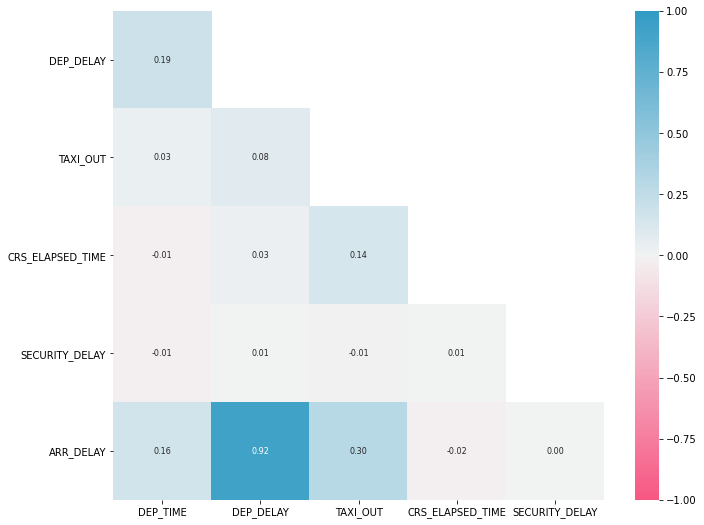

In [14]:
corr_clean2 = df_clean2.corr()
print_corr_matrix(corr_clean2)

#### Correlation Interpretation
Now that we selected our subset of features, we can already see that there is a strong correlation between the feature we want to predict (i.e. `ARR_DELAY`) and `DEP_DELAY`, there is also a significant correlation with `TAXI_OUT`. Therefore `DEP_DELAY` and `TAXI_OUT` should both be good predictors for `ARR_DELAY`.

#### Prediction using linear regression
Linear regression is good algorithm when features have high correlation (i.e. linear dependencies) with the output feature. Therefore we try to optimize a linear regression model with input features `DEP_DELAY` and `TAXI_OUT`.

# 2 - Model constrution and training
Now that we selected the set of features to perform linear regression on, we create a spark Scala project.
We first load the data in a Spark Dataframe before building the model.
\
![](images/image1.PNG)
\
![](images/image2.PNG)

#### Model construction
In our case we will use a simple linear regression model provided by the `LinearRegression` class of the MLlib library.
\
![](images/image3.PNG)

#### Model training
We train our model using the `TrainValidationSplit` class, which will create a validation set to train the data on.

# 3 - Training our model in a cloud cluster (AWS Elastic Map Reduce, S3)
We decide to use the Elastic Map Reduce AWS service in order to train our model in a powerful cloud cluster.\
In order to do that, we compile our scala program into a .jar file (using the `package` command in sbt).
Then we create an S3 bucket and send both our .jar file containing the scala program and the dataset.
After initializing the EMR cluster and logging with SSH, we transfer the .jar from S3 to EMR with \
`aws s3 cp s3://.......... .`.
Finally we can launch our jar file with `spark-submit`